<a href="https://colab.research.google.com/github/namanjain59/PredictFutureSales/blob/master/PredictFutureSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Link Google Drive (containing Data) with the current notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import packages and set the path of all the input files

In [0]:
import numpy as np
import pandas as pd 
from itertools import product
from tqdm import tqdm_notebook
import gc
import matplotlib.pyplot as plt

import sklearn
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pickle


pathData = "drive/My Drive/Colab Notebooks/PredictFutureSales/"
datap = pathData+"Datasets/"
pathItem_Categories = datap+"item_categories.csv"
pathItems = datap+"items.csv"
pathShops = datap+"shops.csv"
pathSales_train = datap+"sales_train.csv"
pathTest = datap+"test.csv"
pathSample_submission = datap+"sample_submission.csv"


# Utility funtion to downcast the datatypes
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

#Load Data

In [0]:
items = pd.read_csv(pathItems)
item_cat = pd.read_csv(pathItem_Categories)
shops = pd.read_csv(pathShops)
sales = pd.read_csv(pathSales_train)
test = pd.read_csv(pathTest)
samplesub = pd.read_csv(pathSample_submission)

#Exploratory Data Analysis

In [4]:
print(items.describe())
print(items.nunique())
print(items.head(5))


           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000         58.000000
max    22169.00000         83.000000
item_name           22170
item_id             22170
item_category_id       84
dtype: int64
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40


In [5]:
print(item_cat.describe())
print(item_cat.nunique())
print(item_cat.head(5))

       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
item_category_name    84
item_category_id      84
dtype: int64
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


In [6]:
print(shops.describe())
print(shops.nunique())
print(shops.head(5))

         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000
shop_name    60
shop_id      60
dtype: int64
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


In [7]:
print(sales.describe())
print(sales.nunique())
print(sales.head(5))

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00        

In [8]:
testmod = test
test_block = sales['date_block_num'].max() + 1
testmod['date_block_num']=sales.date_block_num.max()+1
testmod.drop(columns='ID', inplace=True)
testmod.head(5)

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [9]:
samplesub.head(5)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


As can be seens above,

* There are 22170 unique item_id
*  There are 60 unique shop_id
*  There are 60 unique item_category_id

Also, the number of items for each month (block) seems to be well distributed

AxesSubplot(0.125,0.125;0.775x0.755)
                 count
date_block_num        
0               115690
1               108613
2               121347
3                94109
4                91759
5               100403
6               100548
7               104772
8                96137
9                94202
10               96736
11              143246
12               99349
13               89830
14               92733
15               77906
16               78529
17               82408
18               78760
19               86614
20               73157
21               79361
22               86428
23              130786
24               88522
25               71808
26               69977
27               56274
28               54548
29               54617
30               55549
31               57029
32               50588
33               53514


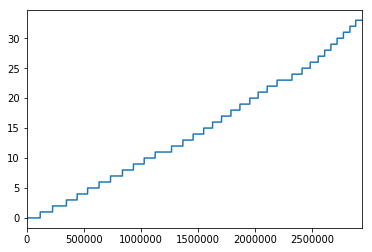

In [10]:
print(sales.date_block_num.plot())
print(sales[['date_block_num', 'shop_id']].groupby('date_block_num').agg('count').rename(columns={'shop_id':'count'}))

##Removing Outliers
Items with item_id 20949, 11373 and 6066 seems to be outliers (Having abnormally large values). So we remove them from the dataset

AxesSubplot(0.125,0.125;0.775x0.755)
              sum
item_id          
20949    187642.0
2808      17245.0
3732      16642.0
17717     15830.0
5822      14515.0
3734      11688.0
6675      10289.0
3731      10099.0
1855      10032.0
16787      9227.0
7856       9012.0
4181       8869.0
3331       8262.0
2445       7788.0
2308       7588.0
4870       7551.0
6738       7351.0
2814       7105.0
1830       6975.0
11373      6563.0
                                               item_name  ...  item_category_id
20949  Фирменный пакет майка 1С Интерес белый (34*42)...  ...                71

[1 rows x 3 columns]
                                  item_name  item_id  item_category_id
11373  Доставка до пункта выдачи (Boxberry)    11373                 9
         item_cnt_day  item_id
2909818        2169.0    11373
2326930        1000.0    20949
2864235         669.0     9248
2851091         637.0     9249
2608040         624.0     3731
2626181         539.0    11373
2851073         533.0     

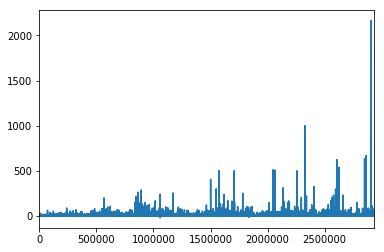

In [11]:
print(sales.item_cnt_day.plot())
print(sales[['item_cnt_day','item_id']].groupby('item_id').agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'sum'}).sort_values(by='sum', ascending=False).head(20))
print(items[items['item_id'] == 20949])
print(items[items['item_id'] == 11373])
print(sales[['item_cnt_day','item_id']].sort_values(by='item_cnt_day', ascending=False).head(20))

AxesSubplot(0.125,0.125;0.775x0.755)
         item_price  item_id
1163158    307980.0     6066
885138      59200.0    11365
1488135     50999.0    13199
2327159     49782.0     7241
2931380     42990.0    13403
2917760     42990.0    13403
2910156     42990.0    13403
2885692     42990.0    13403
1006638     42000.0     7238
2910155     41990.0    13403
2893100     41990.0    13403
2913267     41990.0    13403
2927572     40991.0    13403
2143903     40900.0    14173
2885694     37991.0    13403
2932637     37991.0    13403
1592289     36990.0     5748
1394150     36990.0     5748
1656109     36990.0     5748
884848      36990.0     2410
                 item_name  item_id  item_category_id
6066  Radmin 3  - 522 лиц.     6066                75


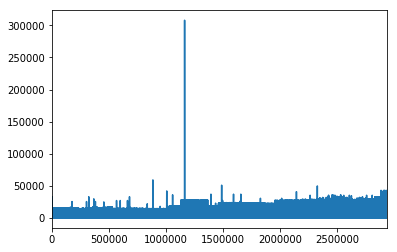

In [12]:
print(sales.item_price.plot())
print(sales[['item_price','item_id']].sort_values(by='item_price', ascending=False).head(20))
print(items[items['item_id']==6066])

In [13]:
print(test[test['item_id']==20949].count())
print(test[test['item_id']==11373].count())
print(test[test['item_id']==6066].count())

shop_id           42
item_id           42
date_block_num    42
dtype: int64
shop_id           42
item_id           42
date_block_num    42
dtype: int64
shop_id           0
item_id           0
date_block_num    0
dtype: int64


The two item id's doesn't have any significant presence in the dataset. So we remove them.

In [0]:
sales=sales[sales['item_price']<100000]
sales=sales[sales['item_cnt_day']<1000]

#Pre Processing and Feature Engineering

###Creating Grid with all shops, items, block information. And the appending the test block (blick number 34). So that the pre processing and feature engineering can take place on both.

In [15]:
index_cols = ['shop_id','item_id', 'date_block_num']
grid=[]


for block in sales['date_block_num'].unique():
  curShop = sales.loc[sales['date_block_num']==block, 'shop_id'].unique()
  curItem = sales.loc[sales['date_block_num']==block, 'item_id'].unique()
  grid.append(np.array(list(product(*[curShop,curItem,[block]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns=index_cols,dtype='int32')
grid = pd.concat([grid, testmod], ignore_index=True)
grid=downcast_dtypes(grid)

KeyboardInterrupt: ignored

In [0]:
grid['date_block_num'].unique()

###Creating features by grouping shops, items, months

In [0]:
gb = sales.groupby(index_cols, as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day':'target'})
all_data= pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [0]:
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'target_item'})
all_data= pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

In [0]:
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'target_shop'})
all_data= pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

In [0]:
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [0]:
all_data.head()

###Creating lag features with previous months data (Different lags are used)

In [0]:
lag_cols=list(all_data.columns.difference(index_cols))
shift_range = [1,2,3,4,5,12]

for shift in tqdm_notebook(shift_range):
  train_shift = all_data[index_cols+lag_cols].copy()
  train_shift['date_block_num']=train_shift['date_block_num']+shift
  cc = lambda x: "{}_lag_{}".format(x, shift) if x in lag_cols else x
  train_shift=train_shift.rename(columns=cc)
  
  all_data= pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
  
del train_shift
all_data.head()

###Add "item category id" as a feature and use only recent data (from the year 2013)

In [0]:
all_data=all_data[all_data['date_block_num']>=12]

fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']

item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect()

###Split Train and Test Data

In [0]:
dates = all_data['date_block_num']

dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

In [0]:
X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

In [0]:
X_train.head()

### Clip target range to [0,20]

In [0]:
target_range = [0, 20]

# Modelling

###Linear Regression

In [0]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [0]:
submission = pd.DataFrame({'ID': samplesub.ID, 'item_cnt_month': pred_lr})
with open(pathData+'Predictions/submission_linear_regression.csv','w+') as f:
  submission.to_csv(f, index=False)

###LightGBM

In [0]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }


In [0]:
model = lgb.train(lgb_params, lgb.Dataset(X_train.values, label=y_train),100)
pred_lgb = model.predict(X_test.values).clip(*target_range)

submission_lgb = pd.DataFrame({'ID': samplesub.ID, 'item_cnt_month': pred_lgb})
with open(pathData+'Predictions/submission_lightGBM.csv','w+') as f:
  submission_lgb.to_csv(f, index=False)

In [0]:
pkl_filename = "Models/lgb_classifier.pkl"  
with open(pathData+pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [0]:
X_testlevel2 = np.c_[pred_lr, pred_lgb]

In [0]:
print(submission.head())
print(submission_lgb.head())

In [0]:
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

###KFold scheme in time series

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.


1.   Split the train data into chunks of duration T. Select first M chunks.
2.   Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
3. Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.


Here, we will use duration T equal to month and M=15.

That is, you need to get predictions (meta-features) from linear regression and LightGBM for months 27, 28, 29, 30, 31, 32, 33. Use the same parameters as in above models.

In [0]:
dates_train_ts = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

In [0]:
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

for cur_block in tqdm_notebook([27, 28, 29, 30, 31, 32, 33]):
  X_trainC = all_data.loc[dates < cur_block].drop(to_drop_cols, axis=1)
  y_trainC = all_data.loc[dates < cur_block, 'target'].values
  
  X_testC = all_data.loc[dates == cur_block].drop(to_drop_cols, axis=1)
  y_testC = all_data.loc[dates == cur_block, 'target'].values
  
  lr.fit(X_trainC, y_trainC)
  pred_lr2 = lr.predict(X_testC).clip(*target_range)
  
  model = lgb.train(lgb_params, lgb.Dataset(X_trainC, label=y_trainC), 100)
  pred_lgb2 = model.predict(X_testC).clip(*target_range)
  
  X_train_level2[dates_train_ts==cur_block, 0] = pred_lr2
  X_train_level2[dates_train_ts==cur_block, 1] = pred_lgb2
  

In [0]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

#Ensembling
Now we'll ensemble our model using the meta features that are created.

##Stacking
Here, we try to fit a linear regression model to the meta-features. Using the same parameters as in the model above.

In [0]:
lr.fit(X_train_level2, y_train_level2)
pred_lr_stacking = lr.predict(X_testlevel2).clip(*target_range)

In [0]:
submission_stacking = pd.DataFrame({'ID': samplesub.ID, 'item_cnt_month': pred_lr_stacking})
with open(pathData+'Predictions/submission_stacking.csv','w+') as f:
  submission.to_csv(f, index=False)

##Simple convex mix

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$
We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of alphas_to_try array. Remember, that we need to use train meta-features (not test) when searching for $\alpha$.

In [0]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

In [0]:
pred_averaging = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb

In [0]:
submission_averaging = pd.DataFrame({'ID': samplesub.ID, 'item_cnt_month': pred_averaging})
with open(pathData+'Predictions/submission_averaging.csv','w+') as f:
  submission.to_csv(f, index=False)